In [1]:
from src.capstone.evaluation import Evaluator
from src.capstone.cbf import CBF, InfeasibilityError
from src.capstone.settings import Env
from src.capstone.noise import LunarLanderNoise
from src.capstone.nndm import NNDM
from src.capstone.ddpg import Actor

import numpy as np
import gymnasium as gym

from bound_propagation.polynomial import Pow
from bound_propagation.linear import FixedLinear

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm

We make a plot similar to the Quadruped example of the Robust Safety paper (figure 1). In this case, we apply a simple constraint: an x range $[-0.2, 0.2]$ in which the Lander must remain. This corresponds to the positions of the flags that mark the landing area.

$$h(x) = 1 - \frac{x^2}{0.2^2} = 1-25x^2$$

In [2]:
# allows to set a bound (also on other values than x = 0.2)
x_bound = 0.15

In [3]:
class ContinuousLunarLander(Env):

    def __init__(self, noise: list[float]) -> None:
        env = gym.make("LunarLander-v2", continuous=True)
        
        self.is_discrete = False

        self.settings = {
            'noise': {
                'x': noise[0],
                'y': noise[1],
                'theta': noise[2],
                'v_x': noise[3],
                'v_y': noise[4],
                'v_theta': noise[5]
            },

            'replay_size': 1_000_000,
            'batch_size': 128,
            'num_episodes': 3000,
            'max_frames': 1000,  # so that the lander prioritizes landing quick

            'gamma': 0.99,
            'tau': 0.001,

            'NNDM_layers': (64,),
            'NNDM_activation': nn.Tanh,
            'NNDM_criterion': nn.MSELoss,
            'NNDM_optim': optim.Adam,
            'NNDM_lr': 1e-3,

            'Actor_layers': (256, 128, 64),
            'Actor_activation': F.relu,
            'Actor_optim': optim.AdamW,
            'Actor_lr': 1e-4,
            'Action_bound': 1.,  # action space is bounded to [-1, 1] - see gymnasium docs

            'Critic_layers': {'s': (256, 128), 'a': (128,), 'concat': (128,)},
            'Critic_activation': F.relu,
            'Critic_criterion': nn.SmoothL1Loss,
            'Critic_optim': optim.AdamW,
            'Critic_lr': 1e-3,

            'OU_mu': 0,
            'OU_theta': 0.15,
            'OU_sigma': 0.2
        }

        self.h_function = nn.Sequential(
            FixedLinear(
                torch.tensor([
                    [1., 0, 0, 0, 0, 0, 0, 0]
                ]),
                torch.tensor([0.])
            ),
            Pow(2),
            FixedLinear(
                torch.tensor([
                    [-1 / x_bound ** 2]
                ]),
                torch.tensor([1.])
            )
        )

        self.h_ids = [0]
        self.std = [noise[i] for i in self.h_ids]
        self.env = LunarLanderNoise(env, self.settings['noise'])

In [4]:
# positions - 0.005, velocities - 0.025
env = ContinuousLunarLander([0.025, 0.025, 0.05, 0.05, 0.025, 0.05])

# Alpha

$$\nabla^2 h = \begin{bmatrix}
-50
\end{bmatrix}$$

$$\nabla^2 h^T \ \nabla^2 h = \begin{bmatrix}
2500
\end{bmatrix}$$

$$det(\nabla^2 h^T \ \nabla^2 h - \sigma I) = 2500 - \sigma = 0$$

$$\sigma = 2500$$

$$\lambda_{max} = \sqrt{\sigma} = 50$$

In [5]:
lambda_max = 50

stds = [0.005, 0.005, 0.025, 0.025, 0.005, 0.025]
tr_cov = sum(std ** 2 for std in stds)

psi = (lambda_max / 2) * tr_cov
alpha = 1 - psi

print(f'Alpha is {round(alpha, 3)}')

Alpha is 0.951


# NNDM

In [6]:
nndm = NNDM(env)
nndm_params = torch.load(f'../models/NNDMs/{type(env).__name__}')
nndm.load_state_dict(nndm_params)

<All keys matched successfully>

# Agent

In [7]:
policy = Actor(env)
policy_params = torch.load(f'../models/Agents/{type(env).__name__}')
policy.load_state_dict(policy_params)

<All keys matched successfully>

# Evaluate

In [8]:
cbf = CBF(env, nndm, policy,
          alpha=[alpha],
          delta=[0.],
          no_action_partitions=4,
          no_noise_partitions=8,
          stochastic=True)

In [9]:
def mc_simulate(num_agents, cbf_enabled=False, seed=42):
    trajectories = []
    unsafe_frames = []

    for _ in tqdm(range(num_agents)):
        xy_list = []
        state, _ = env.env.reset(seed=seed)
        xy_list.append(state[:2])
        
        state = torch.tensor(state).unsqueeze(0)

        current_frame = 0
        done = False

        while not done:
            if cbf_enabled:
                try:
                    action = cbf.safe_action(state)
                except InfeasibilityError:
                    action = policy.select_action(state, exploration=False)
            else:
                action = policy.select_action(state, exploration=False)

            state, reward, terminated, truncated, _ = env.env.step(action.squeeze().detach().numpy())
            xy_list.append(state[:2])
            
            state = torch.tensor(state).unsqueeze(0)

            current_frame += 1

            if torch.any(env.h_function(state.unsqueeze(0)) < 0).item():
                unsafe_frames.append(current_frame)
                terminated = True

            done = terminated or truncated
        trajectories.append(np.array(xy_list))

    env.env.close()
    return unsafe_frames, trajectories

In [10]:
def plot_paths(num_agents=50):
    agent_frames, agent_trajectories = mc_simulate(num_agents)
    cbf_frames, cbf_trajectories = mc_simulate(num_agents, cbf_enabled=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    
    for agent_run in agent_trajectories:
        ax[0].plot(*zip(*agent_run), color='r', alpha=0.1)
    
    for cbf_run in cbf_trajectories:
        ax[1].plot(*zip(*cbf_run), color='g', alpha=0.1)
    
    ax[0].plot(*zip(agent_trajectories[0][0]), marker='o', color='black', markersize=5)
    ax[1].plot(*zip(cbf_trajectories[0][0]), marker='o', color='black', markersize=5)
        
    ax[0].vlines([-x_bound, x_bound], 0., 1.5, colors='black', linestyles='dashed')
    ax[1].vlines([-x_bound, x_bound], 0., 1.5, colors='black', linestyles='dashed')
    
    ax[0].set_xlim(-0.3, 0.3)
    ax[1].set_xlim(-0.3, 0.3)
    
    ax[0].set_ylim(0., 1.5)
    ax[1].set_ylim(0., 1.5)
    
    ax[0].set_title(f'No filter - {len(agent_frames)} violations')
    ax[1].set_title(f'Stochastic CBF - {len(cbf_frames)} violations')
    
    plt.savefig('plots/LunarLander.png')
    plt.show()

100%|██████████| 50/50 [05:31<00:00,  6.64s/it]


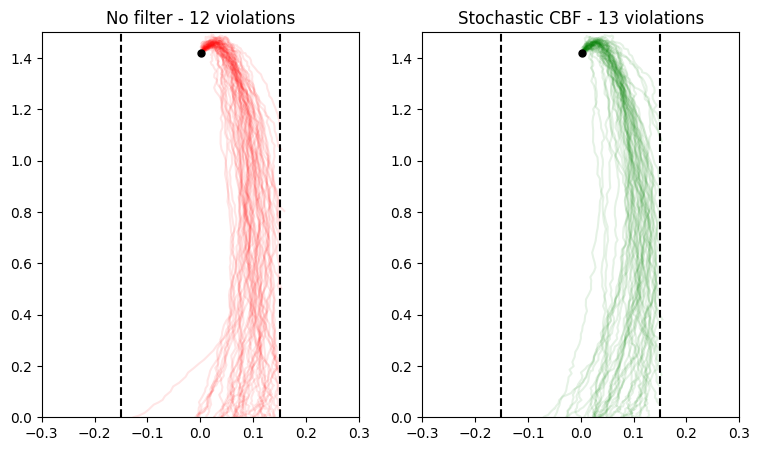

In [11]:
plot_paths(50)